In [1]:
import os
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
# Utility imports
import rfa_utils.general_fns as gf
import rfa_utils.clean_crypto as cc
import rfa_utils.coingecko_api as ca
import rfa_utils.crypto_scrape as cs
# EDA import
import rfa_eda.crypto_eda as ceda

In [2]:
# List of crypto symbols and IDs
syms = ['btc', 'xrp', 'doge', 'ltc', 'xmr', 'bch', 'xlm', 'bsv', 'zec', 'dash']
cids = ['bitcoin', 'ripple', 'dogecoin', 'litecoin', 'monero', 'bitcoin-cash', 'stellar', 'bitcoin-cash-sv', 'zcash', 'dash']

# Variables for API call
currency = 'usd'
start_date = '2019/01/01'
end_date = '2022/12/31'

In [3]:
# Check and create API data
api_path = os.path.join('data/crypto/', 'api-data.xlsx')
gf.check_and_create(api_path, ca.create_api_dict, syms, cids, currency, start_date, end_date)

In [4]:
# Set up Chrome headless options
chrome_options = Options()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--disable-gpu')

# Set up the webdriver with the Chrome options
driver = webdriver.Chrome(options=chrome_options)

In [5]:
# Dict of token stats list for scraping
token_stats = {
    'btc': ['bitcoin-transactions', 'bitcoin-transactionvalue', 'bitcoin-mediantransactionvalue', 'bitcoin-transactionfees', 'bitcoin-median_transaction_fee'],
    'xrp': ['xrp-transactions', 'transactionfees-xrp'],
    'doge': ['dogecoin-transactions', 'dogecoin-transactionvalue', 'dogecoin-mediantransactionvalue', 'dogecoin-transactionfees', 'dogecoin-median_transaction_fee'],
    'ltc': ['litecoin-transactions', 'litecoin-transactionvalue', 'litecoin-mediantransactionvalue', 'litecoin-transactionfees', 'litecoin-median_transaction_fee'],
    'xmr': ['monero-transactions', 'monero-transactionfees'],
    'bsv': ['transactions-bsv'],
    'bch': ['bitcoin%20cash-transactions', 'bitcoin%20cash-transactionvalue', 'bitcoin%20cash-mediantransactionvalue', 'bitcoin%20cash-transactionfees', 'bitcoin%20cash-median_transaction_fee'],
    'zec': ['zcash-transactions', 'zcash-transactionfees', 'transactionvalue-zec', 'mediantransactionvalue-zec'],
    'dash': ['dash-transactions', 'dash-transactionfees', 'dash-median_transaction_fee', 'transactionvalue-dash', 'mediantransactionvalue-dash']
}

In [6]:
# Check and create scraped data
scrape_path = os.path.join('data/crypto/', 'scraped-data.xlsx')
gf.check_and_create(scrape_path, cs.create_scrape_dict, token_stats, driver, start_date, end_date)

In [7]:
# Check and create combined Excel file
combined_path = os.path.join('data/crypto/', 'combined-data.xlsx')
if not os.path.exists(combined_path):
    # List of scraped Excel sheets
    scraped_sheets = ['btc', 'xrp_bit', 'xrp_mes', 'doge', 'ltc', 'xmr', 'bsv_bit', 'bsv_mes', 'bch', 'xlm', 'zec', 'dash']
    # Read filled Excel sheets into dataframes
    filled_api = gf.import_excel(
        'data/crypto/filled-api-data.xlsx',
        syms
    )
    filled_scraped = gf.import_excel(
        'data/crypto/filled-scraped-data.xlsx',
        scraped_sheets
    )
    gf.check_and_create(combined_path, cc.merge_api_scraped, filled_api, filled_scraped, syms)

In [8]:
# Check and create imputed file
imputed_path = os.path.join('data/crypto/', 'imputed-data.xlsx')
if not os.path.exists(imputed_path):
    combined = gf.import_excel(
        combined_path,
        syms
    )
    # Impute missing columns with miceforest
    gf.check_and_create(imputed_path, cc.impute_dfs, combined)

In [9]:
# Import imputed dataframes
imputed = gf.import_excel(
    imputed_path,
    syms
)
# Convert to pandas
for df in imputed:
    imputed[df] = imputed[df].to_pandas()

In [10]:
# Print summary stats
ceda.summary_stats(imputed)

>>> BTC
╒═══════╤═══════════╤═══════════════════╤══════════════════╤══════════════════════╤═════════════════════════════╤════════════════════════════╤════════════════════════════╤═══════════════════════════╕
│       │     price │        market_cap │       24h_volume │   transactions_count │   average_transaction_value │   median_transaction_value │   average_transaction_fees │   median_transaction_fees │
╞═══════╪═══════════╪═══════════════════╪══════════════════╪══════════════════════╪═════════════════════════════╪════════════════════════════╪════════════════════════════╪═══════════════════════════╡
│ count │  1461.000 │          1461.000 │         1461.000 │             1461.000 │                    1461.000 │                   1461.000 │                   1461.000 │                  1461.000 │
├───────┼───────────┼───────────────────┼──────────────────┼──────────────────────┼─────────────────────────────┼────────────────────────────┼────────────────────────────┼─────────────────────

In [11]:
# Print transaction fees stats
ceda.fees_stats(imputed)

╒════╤═════════╤═══════╤════════╤═════════╕
│    │ token   │   std │   skew │    kurt │
╞════╪═════════╪═══════╪════════╪═════════╡
│  0 │ btc     │ 6.343 │  4.126 │  23.854 │
├────┼─────────┼───────┼────────┼─────────┤
│  1 │ xrp     │ 0.001 │  2.188 │   4.578 │
├────┼─────────┼───────┼────────┼─────────┤
│  2 │ doge    │ 0.373 │  8.779 │ 156.249 │
├────┼─────────┼───────┼────────┼─────────┤
│  3 │ ltc     │ 0.024 │ 15.000 │ 401.360 │
├────┼─────────┼───────┼────────┼─────────┤
│  4 │ xmr     │ 0.021 │  3.728 │  38.264 │
├────┼─────────┼───────┼────────┼─────────┤
│  5 │ bch     │ 0.005 │  6.767 │  71.062 │
├────┼─────────┼───────┼────────┼─────────┤
│  6 │ xlm     │ 0.000 │  2.003 │   3.133 │
├────┼─────────┼───────┼────────┼─────────┤
│  7 │ bsv     │ 0.005 │  4.109 │  20.193 │
├────┼─────────┼───────┼────────┼─────────┤
│  8 │ zec     │ 2.774 │  0.739 │  -0.506 │
├────┼─────────┼───────┼────────┼─────────┤
│  9 │ dash    │ 0.012 │ 18.839 │ 501.230 │
╘════╧═════════╧═══════╧════════

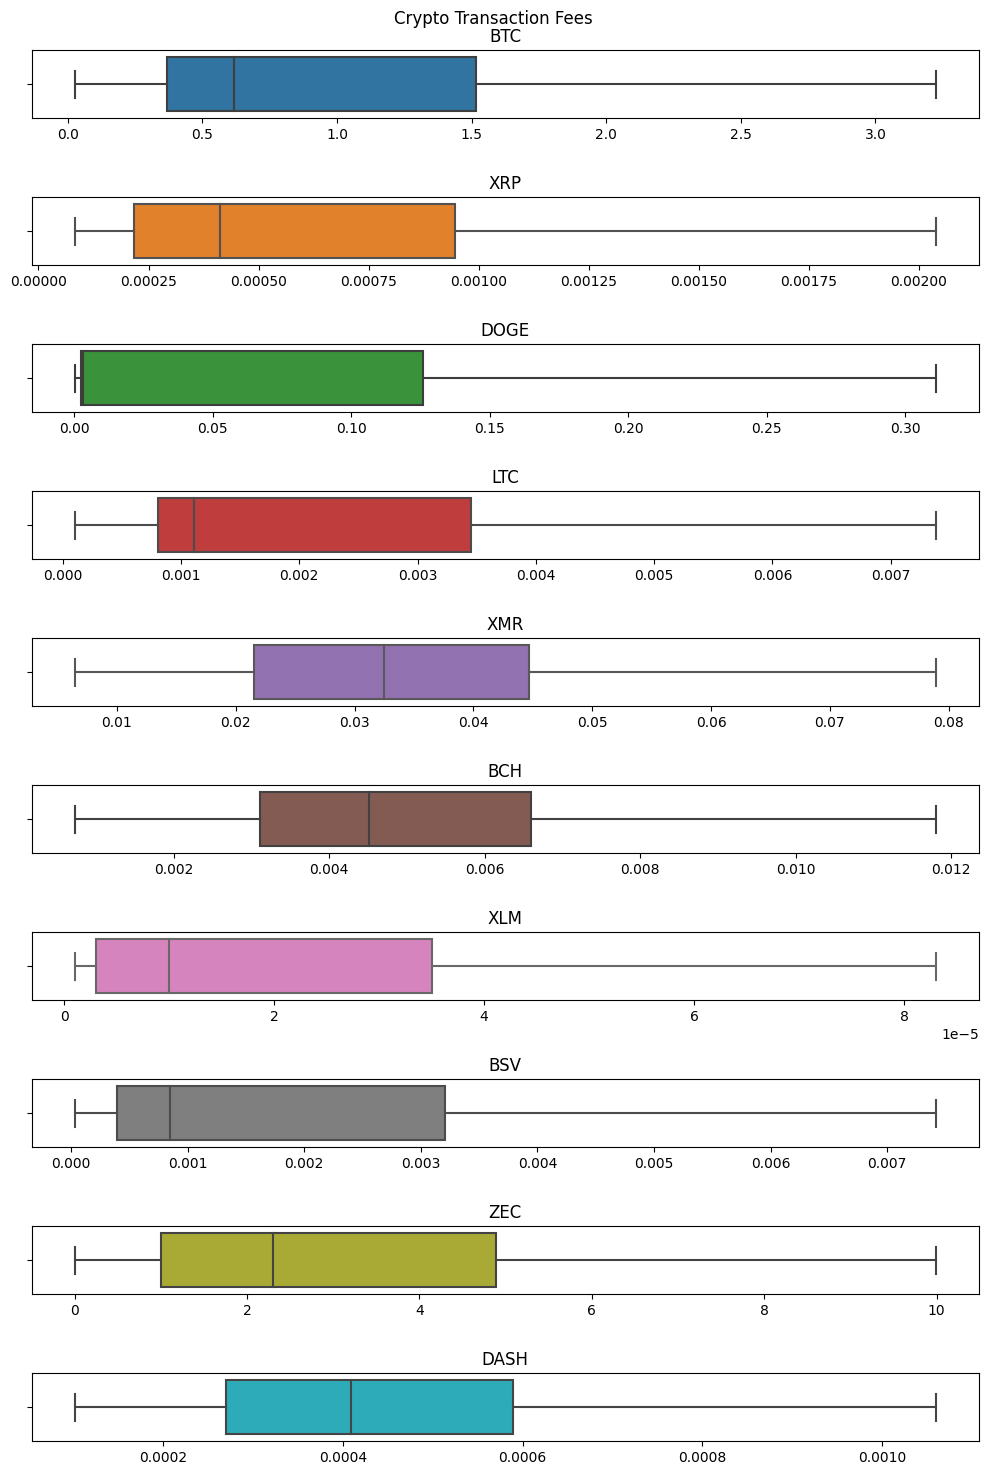

In [12]:
# Plot transaction fees box plots
ceda.fees_boxplots(imputed)

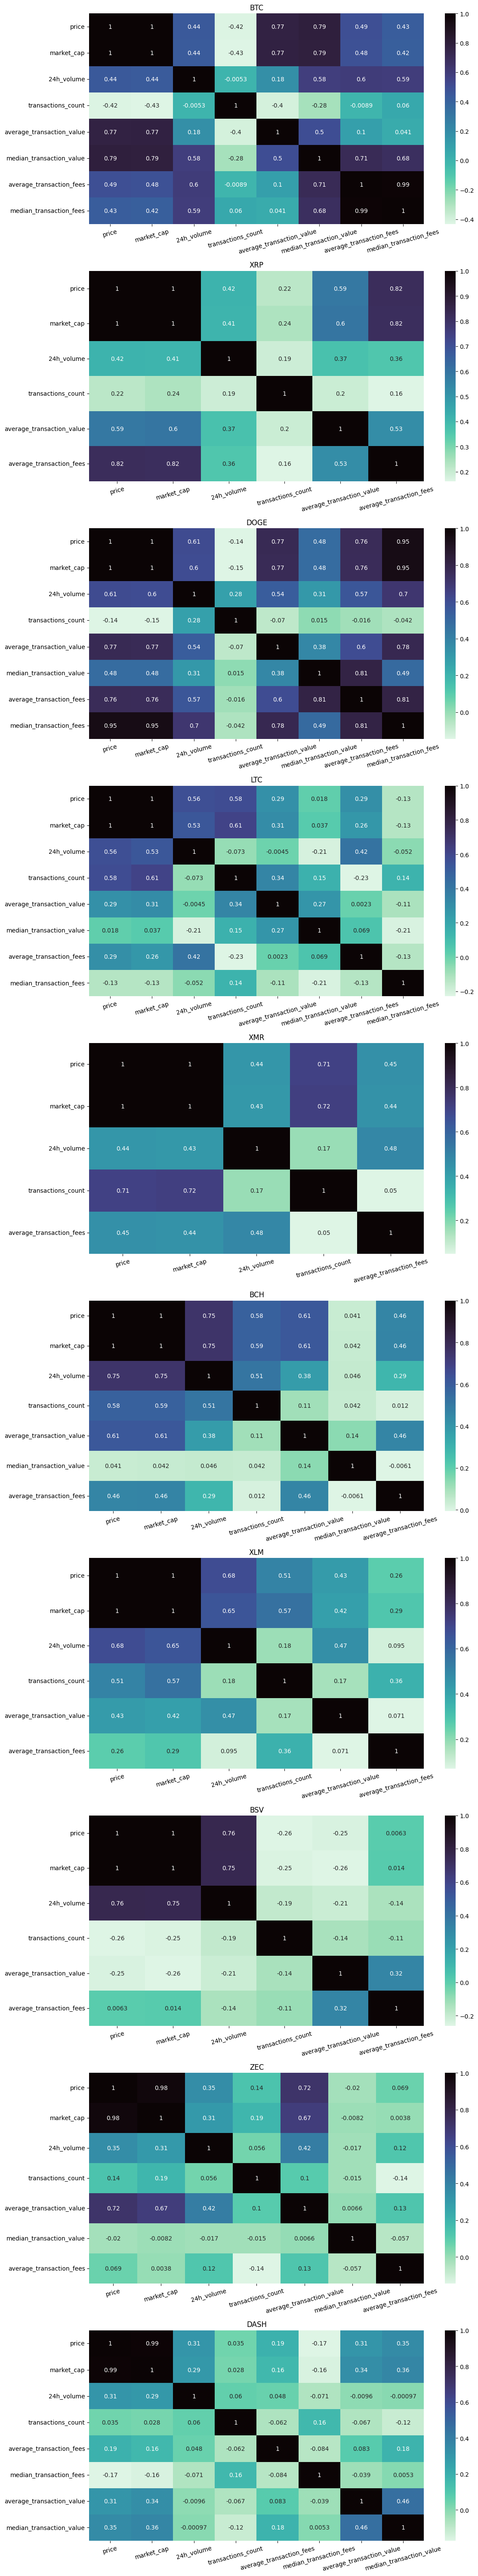

In [13]:
# Plot correlation heatmaps
ceda.corr_heatmaps(imputed)

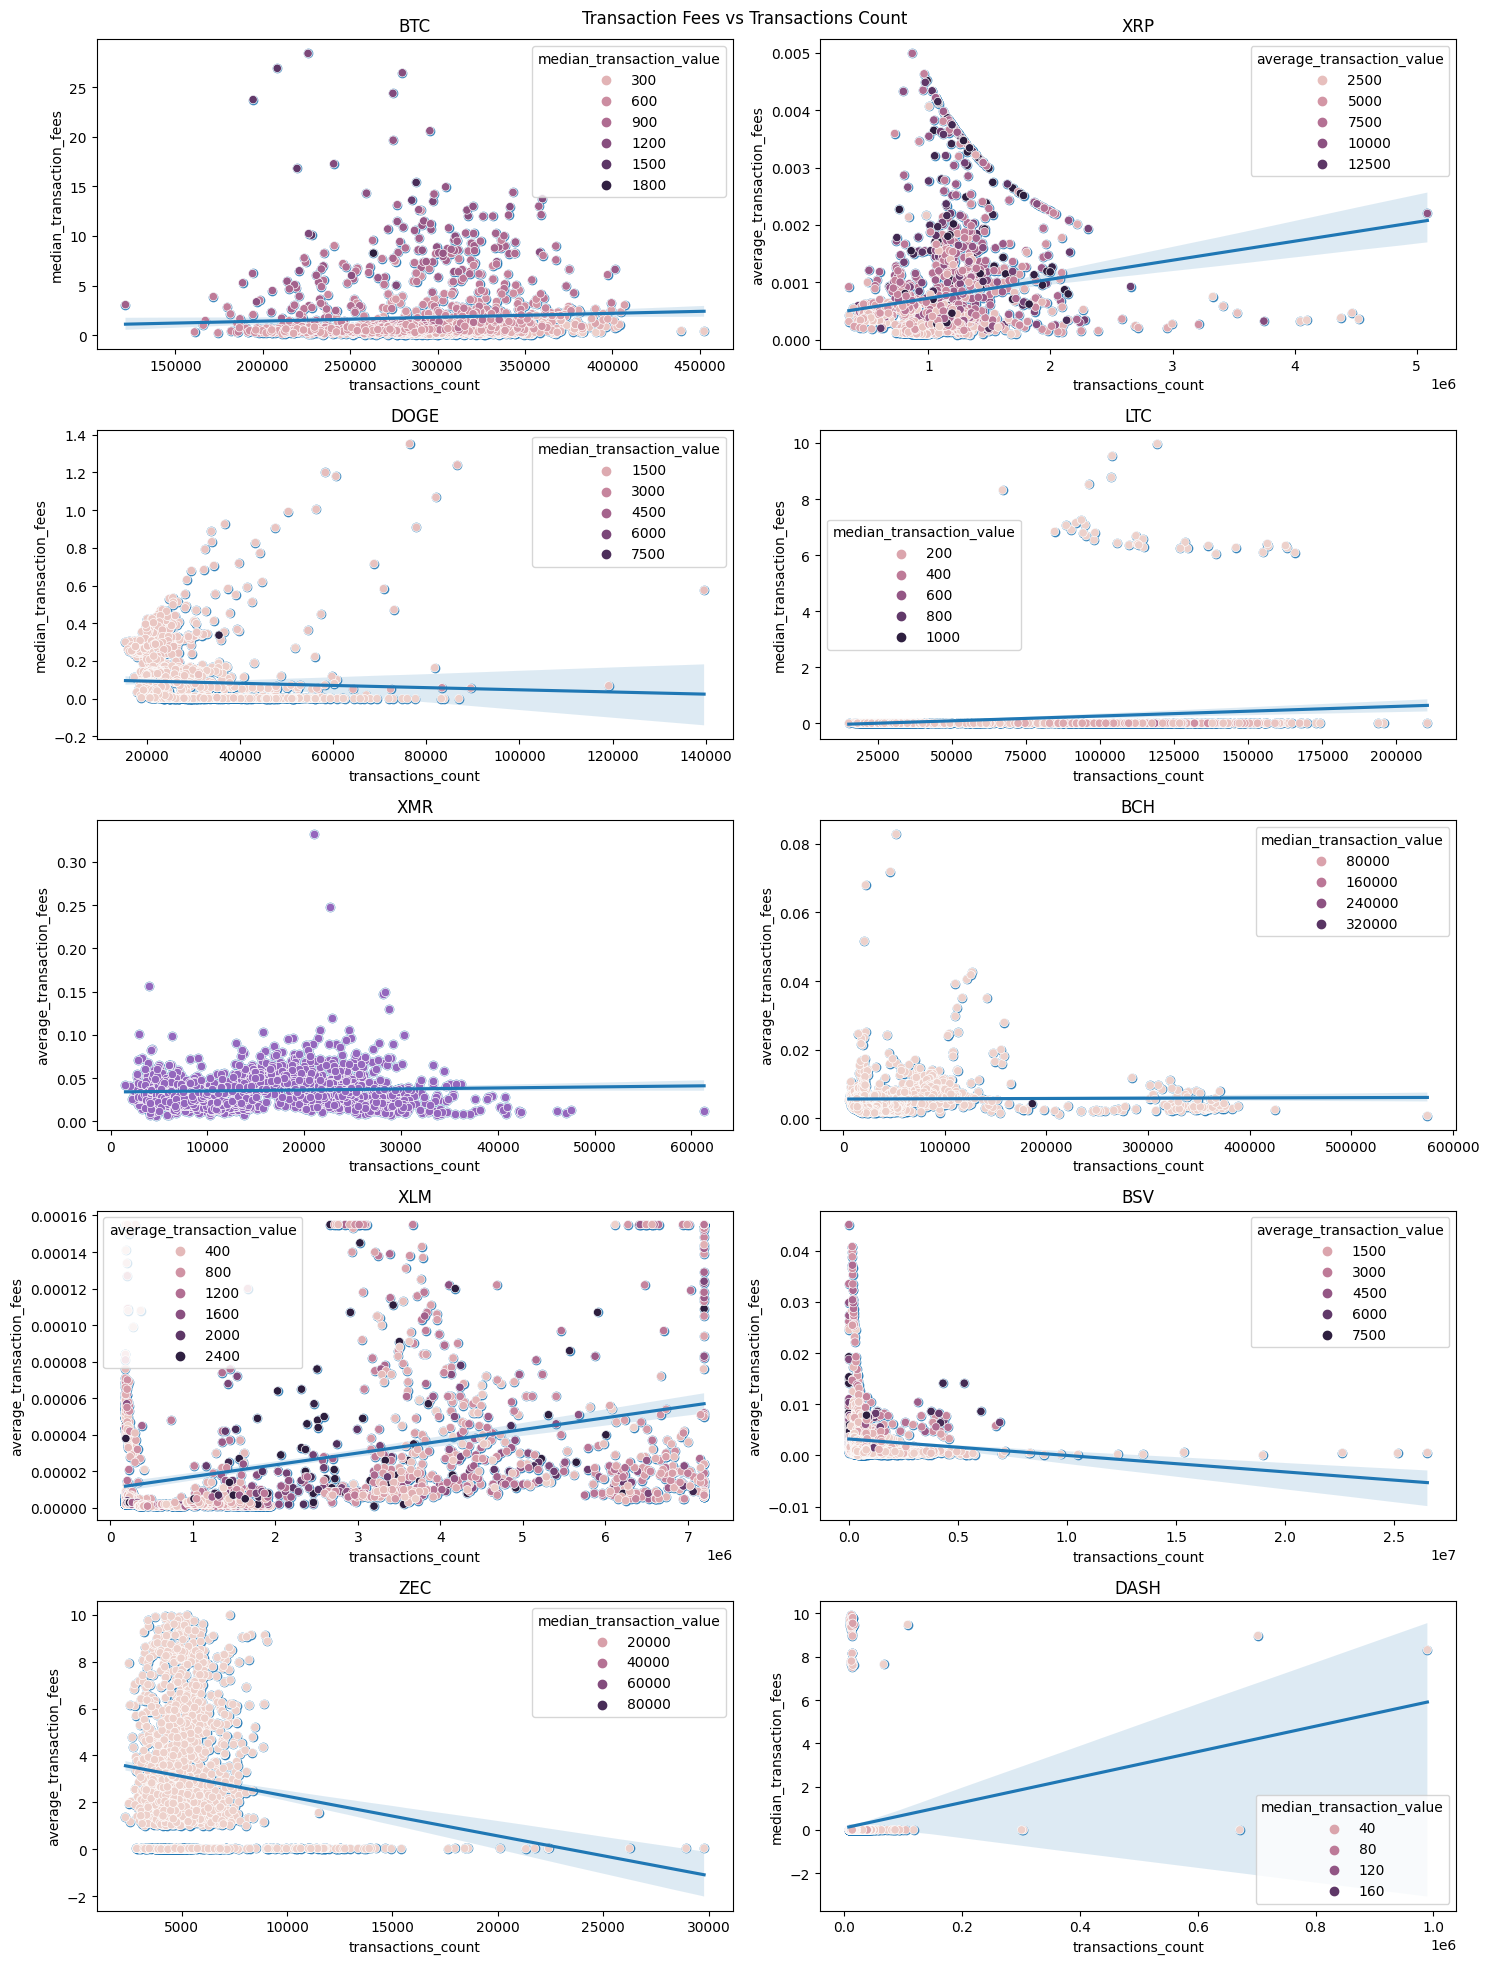

In [14]:
# Plot scatterplot of fees against transaction values
ceda.fees_scatterplots(imputed)